In [64]:
#Importing all required librariers
from pathlib import Path

import pandas as pd
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.neighbors import NearestNeighbors, KNeighborsClassifier
import matplotlib.pylab as plt
import seaborn as sns

%matplotlib inline

import graphviz

import numpy as np
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
import matplotlib.pylab as plt
from sklearn.preprocessing import LabelEncoder
import dmba
from dmba import plotDecisionTree, classificationSummary, regressionSummary

In [65]:
#Loading the data
ebay_df = pd.read_csv('ebayAuctions.csv')
ebay_df.head()

,Category,currency,sellerRating,Duration,endDay,ClosePrice,OpenPrice,Competitive?
0,Music/Movie/Game,US,3249,5,Mon,0.01,0.01,0
1,Music/Movie/Game,US,3249,5,Mon,0.01,0.01,0
2,Music/Movie/Game,US,3249,5,Mon,0.01,0.01,0
3,Music/Movie/Game,US,3249,5,Mon,0.01,0.01,0
4,Music/Movie/Game,US,3249,5,Mon,0.01,0.01,0


In [66]:
#Creating new column to calculate the price difference between open and close prices
ebay_df['Price_Margin'] = ebay_df['ClosePrice']-ebay_df['OpenPrice']
ebay_df.rename(columns={'Competitive?': 'Competitive'}, inplace=True)
ebay_df.head()

,Category,currency,sellerRating,Duration,endDay,ClosePrice,OpenPrice,Competitive,Price_Margin
0,Music/Movie/Game,US,3249,5,Mon,0.01,0.01,0,0.0
1,Music/Movie/Game,US,3249,5,Mon,0.01,0.01,0,0.0
2,Music/Movie/Game,US,3249,5,Mon,0.01,0.01,0,0.0
3,Music/Movie/Game,US,3249,5,Mon,0.01,0.01,0,0.0
4,Music/Movie/Game,US,3249,5,Mon,0.01,0.01,0,0.0


In [67]:
ebay_df.columns

Index(['Category', 'currency', 'sellerRating', 'Duration', 'endDay',
       'ClosePrice', 'OpenPrice', 'Competitive', 'Price_Margin'],
      dtype='object')

In [68]:
ebay_df.describe()

,sellerRating,Duration,ClosePrice,OpenPrice,Competitive,Price_Margin
count,1972.000000,1972.000000,1972.000000,1972.000000,1972.000000,1972.000000
mean,3560.238337,6.486308,36.449087,12.926268,0.540568,23.522819
std,5973.011033,2.052906,89.493858,38.856149,0.498478,78.752786
min,0.000000,1.000000,0.010000,0.010000,0.000000,0.000000
25%,595.000000,5.000000,4.907500,1.230000,0.000000,0.000000
50%,1853.000000,7.000000,9.995000,4.500000,1.000000,0.760000
75%,3380.000000,7.000000,28.000000,9.990000,1.000000,12.290000
max,37727.000000,10.000000,999.000000,999.000000,1.000000,961.010000


In [69]:
#Converting categorical variables into numberical using label encoder
le = LabelEncoder()
ebay_df['Cat_z'] = le.fit_transform(ebay_df['Category'])
ebay_df['currency'] = le.fit_transform(ebay_df['currency'])
ebay_df['endDay'] = le.fit_transform(ebay_df['endDay'])
#Validating categorical values with it's numerical values
category_summary = ebay_df.groupby(['Category', 'Cat_z']).size().reset_index(name='count')
print(category_summary)

                Category  Cat_z  count
0      Antique/Art/Craft      0    177
1             Automotive      1    178
2                  Books      2     54
3    Business/Industrial      3     18
4   Clothing/Accessories      4    119
5           Coins/Stamps      5     37
6           Collectibles      6    239
7               Computer      7     36
8            Electronics      8     55
9         EverythingElse      9     17
10         Health/Beauty     10     64
11           Home/Garden     11    102
12               Jewelry     12     82
13      Music/Movie/Game     13    403
14           Photography     14     13
15         Pottery/Glass     15     20
16         SportingGoods     16    124
17          Toys/Hobbies     17    234


In [70]:
ebay_df['Category']=ebay_df['Cat_z']
ebay_df = ebay_df.drop(['Cat_z'],axis=1)
ebay_df

,Category,currency,sellerRating,Duration,endDay,ClosePrice,OpenPrice,Competitive,Price_Margin
0,13,2,3249,5,1,0.01,0.01,0,0.0
1,13,2,3249,5,1,0.01,0.01,0,0.0
2,13,2,3249,5,1,0.01,0.01,0,0.0
3,13,2,3249,5,1,0.01,0.01,0,0.0
4,13,2,3249,5,1,0.01,0.01,0,0.0
...,...,...,...,...,...,...,...,...,...
1967,1,2,2992,5,3,359.95,359.95,0,0.0
1968,1,2,21,5,2,610.00,300.00,1,310.0
1969,1,2,1400,5,1,549.00,549.00,0,0.0
1970,1,2,57,7,0,820.00,650.00,1,170.0


In [71]:
#Assigning predictors and target values 
predictors = ['Category', 'currency', 'sellerRating', 'Duration', 'endDay',
       'ClosePrice', 'OpenPrice']
outcome = 'Competitive'

In [72]:
ebay_df.describe()

,Category,currency,sellerRating,Duration,endDay,ClosePrice,OpenPrice,Competitive,Price_Margin
count,1972.000000,1972.000000,1972.000000,1972.000000,1972.000000,1972.000000,1972.000000,1972.000000,1972.000000
mean,8.980223,1.384888,3560.238337,6.486308,2.219574,36.449087,12.926268,0.540568,23.522819
std,5.729140,0.881880,5973.011033,2.052906,1.668329,89.493858,38.856149,0.498478,78.752786
min,0.000000,0.000000,0.000000,1.000000,0.000000,0.010000,0.010000,0.000000,0.000000
25%,4.000000,0.000000,595.000000,5.000000,1.000000,4.907500,1.230000,0.000000,0.000000
50%,10.000000,2.000000,1853.000000,7.000000,2.000000,9.995000,4.500000,1.000000,0.760000
75%,13.000000,2.000000,3380.000000,7.000000,3.000000,28.000000,9.990000,1.000000,12.290000
max,17.000000,2.000000,37727.000000,10.000000,6.000000,999.000000,999.000000,1.000000,961.010000


In [73]:
ebay_df = ebay_df.drop(['Price_Margin'],axis=1)


In [74]:
#Partitioning the data
X = ebay_df[predictors]
y = ebay_df[outcome]
train_X, valid_X, train_y, valid_y = train_test_split(X, y, test_size=0.4, random_state=1)
print(X)
print(y)

      Category  currency  sellerRating  Duration  endDay  ClosePrice  \
0           13         2          3249         5       1        0.01   
1           13         2          3249         5       1        0.01   
2           13         2          3249         5       1        0.01   
3           13         2          3249         5       1        0.01   
4           13         2          3249         5       1        0.01   
...        ...       ...           ...       ...     ...         ...   
1967         1         2          2992         5       3      359.95   
1968         1         2            21         5       2      610.00   
1969         1         2          1400         5       1      549.00   
1970         1         2            57         7       0      820.00   
1971         1         2           145         7       2      999.00   

      OpenPrice  
0          0.01  
1          0.01  
2          0.01  
3          0.01  
4          0.01  
...         ...  
1967     

In [75]:
#Decision Tree classification with Max Depth of 7 and minimum values in each node as 50
classTree = DecisionTreeClassifier(criterion='gini',random_state=6, max_depth=7,min_samples_split=50,min_samples_leaf=50)
classTree.fit(X,y)

DecisionTreeClassifier(max_depth=7, min_samples_leaf=50, min_samples_split=50,
                       random_state=6)

In [76]:
print("Classes: {}".format(', '.join([str(label) for label in classTree.classes_])))

Classes: 0, 1


Number of features in the model: 7


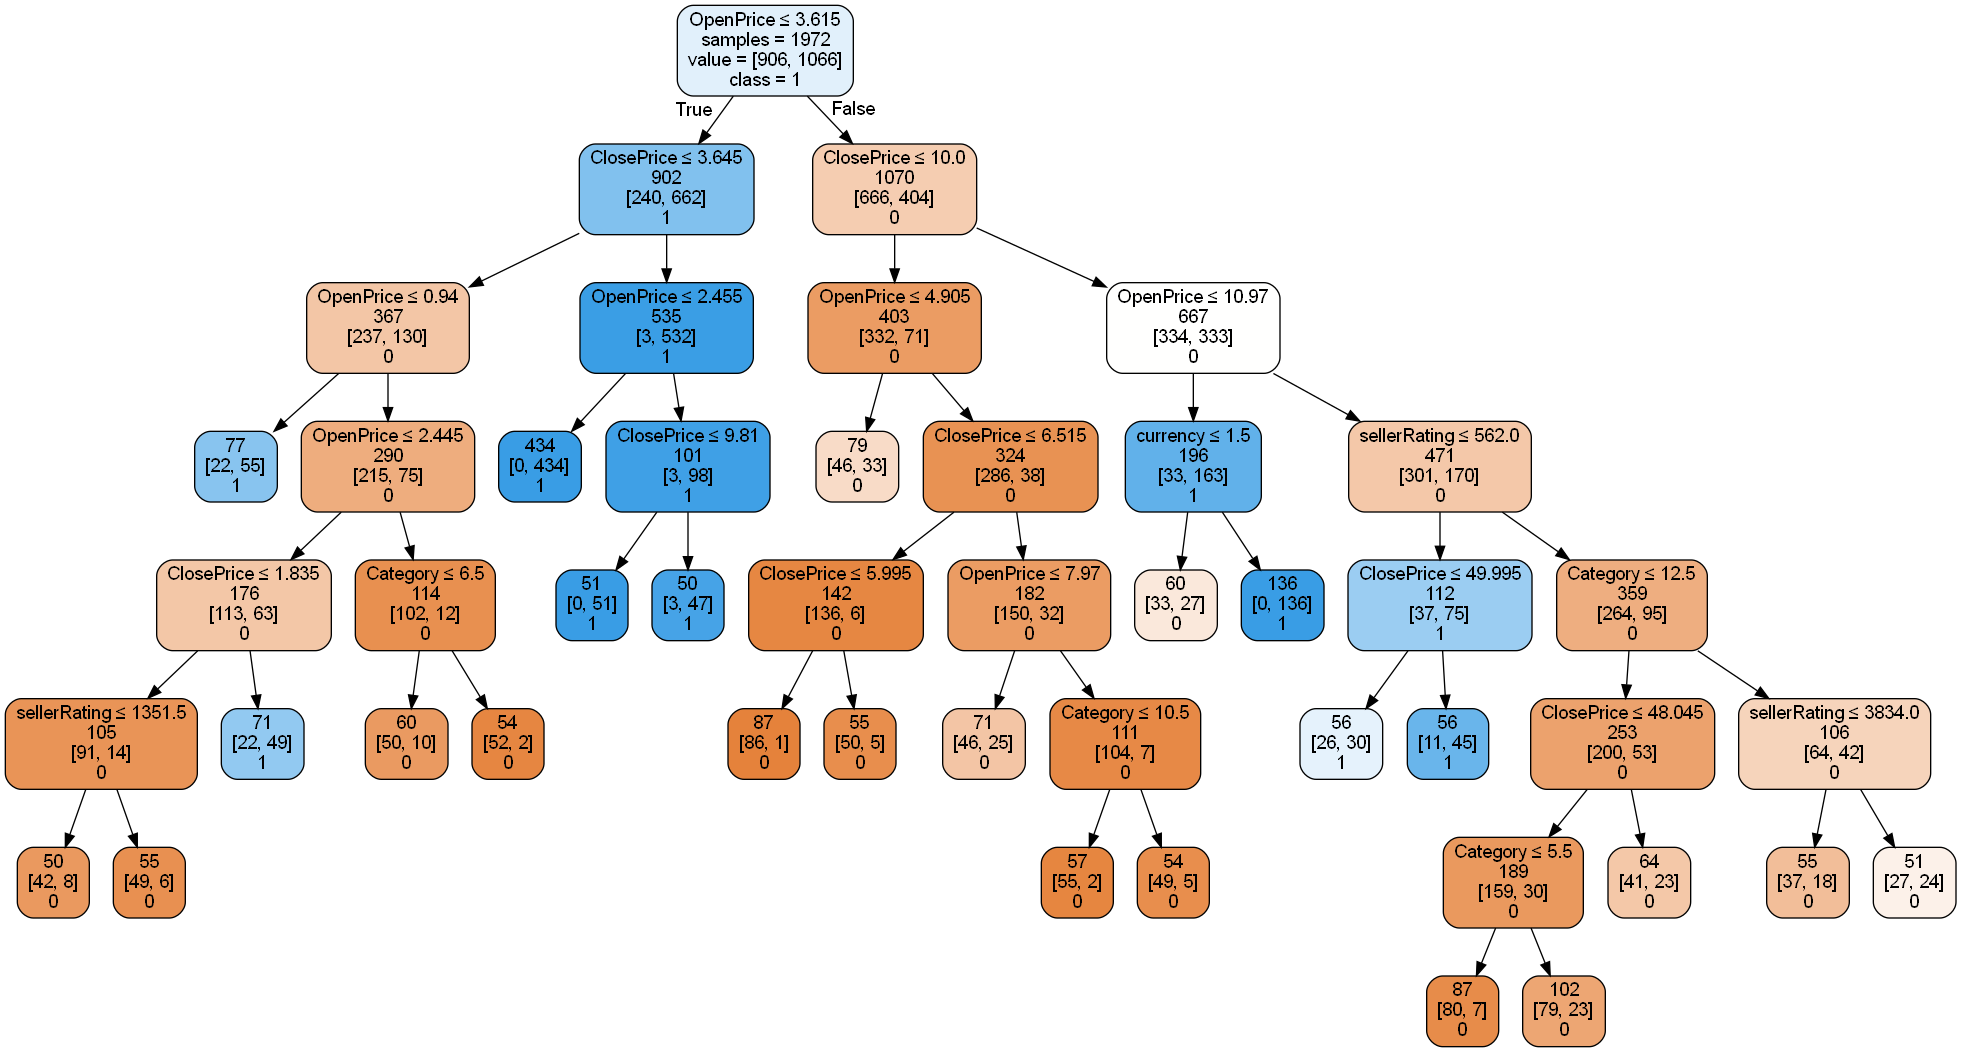

In [77]:
num_features_in_model = classTree.tree_.n_features
print("Number of features in the model:", num_features_in_model)
# Update the feature_names accordingly
feature_names = ebay_df.columns[:num_features_in_model]

# Plot the decision tree
plotDecisionTree(classTree, feature_names=feature_names, class_names=classTree.classes_)

In [79]:
#Accuracy
classificationSummary(ebay_df['Competitive'], classTree.predict(ebay_df.drop(columns=['Competitive'])))

Confusion Matrix (Accuracy 0.8463)

       Prediction
Actual   0   1
     0 822  84
     1 219 847


## The Above model is not compatible to check whether the particular item is competitive or not before the Auction as we lack the closing price, EndDay for an item

### Let's build another classification model exluding these future variables and include only the variables that can help in determining whether the product is competitive or not

In [80]:
ebay_df = ebay_df.drop(['currency','endDay','ClosePrice'],axis=1)
ebay_df.head()

,Category,sellerRating,Duration,OpenPrice,Competitive
0,13,3249,5,0.01,0
1,13,3249,5,0.01,0
2,13,3249,5,0.01,0
3,13,3249,5,0.01,0
4,13,3249,5,0.01,0


In [81]:
predictors = ['Category','sellerRating', 'Duration', 'OpenPrice']
outcome = 'Competitive'

In [82]:
X = ebay_df[predictors]
y = ebay_df[outcome]
train_X, valid_X, train_y, valid_y = train_test_split(X, y, test_size=0.4, random_state=1)
print(X)
print(y)


      Category  sellerRating  Duration  OpenPrice
0           13          3249         5       0.01
1           13          3249         5       0.01
2           13          3249         5       0.01
3           13          3249         5       0.01
4           13          3249         5       0.01
...        ...           ...       ...        ...
1967         1          2992         5     359.95
1968         1            21         5     300.00
1969         1          1400         5     549.00
1970         1            57         7     650.00
1971         1           145         7     999.00

[1972 rows x 4 columns]
0       0
1       0
2       0
3       0
4       0
       ..
1967    0
1968    1
1969    0
1970    1
1971    0
Name: Competitive, Length: 1972, dtype: int64


In [83]:
classTree = DecisionTreeClassifier(criterion='gini',random_state=6, max_depth=7,min_samples_split=50,min_samples_leaf=50)
classTree.fit(X,y)
print("Classes: {}".format(', '.join([str(label) for label in classTree.classes_])))

Classes: 0, 1


Number of features in the model: 4


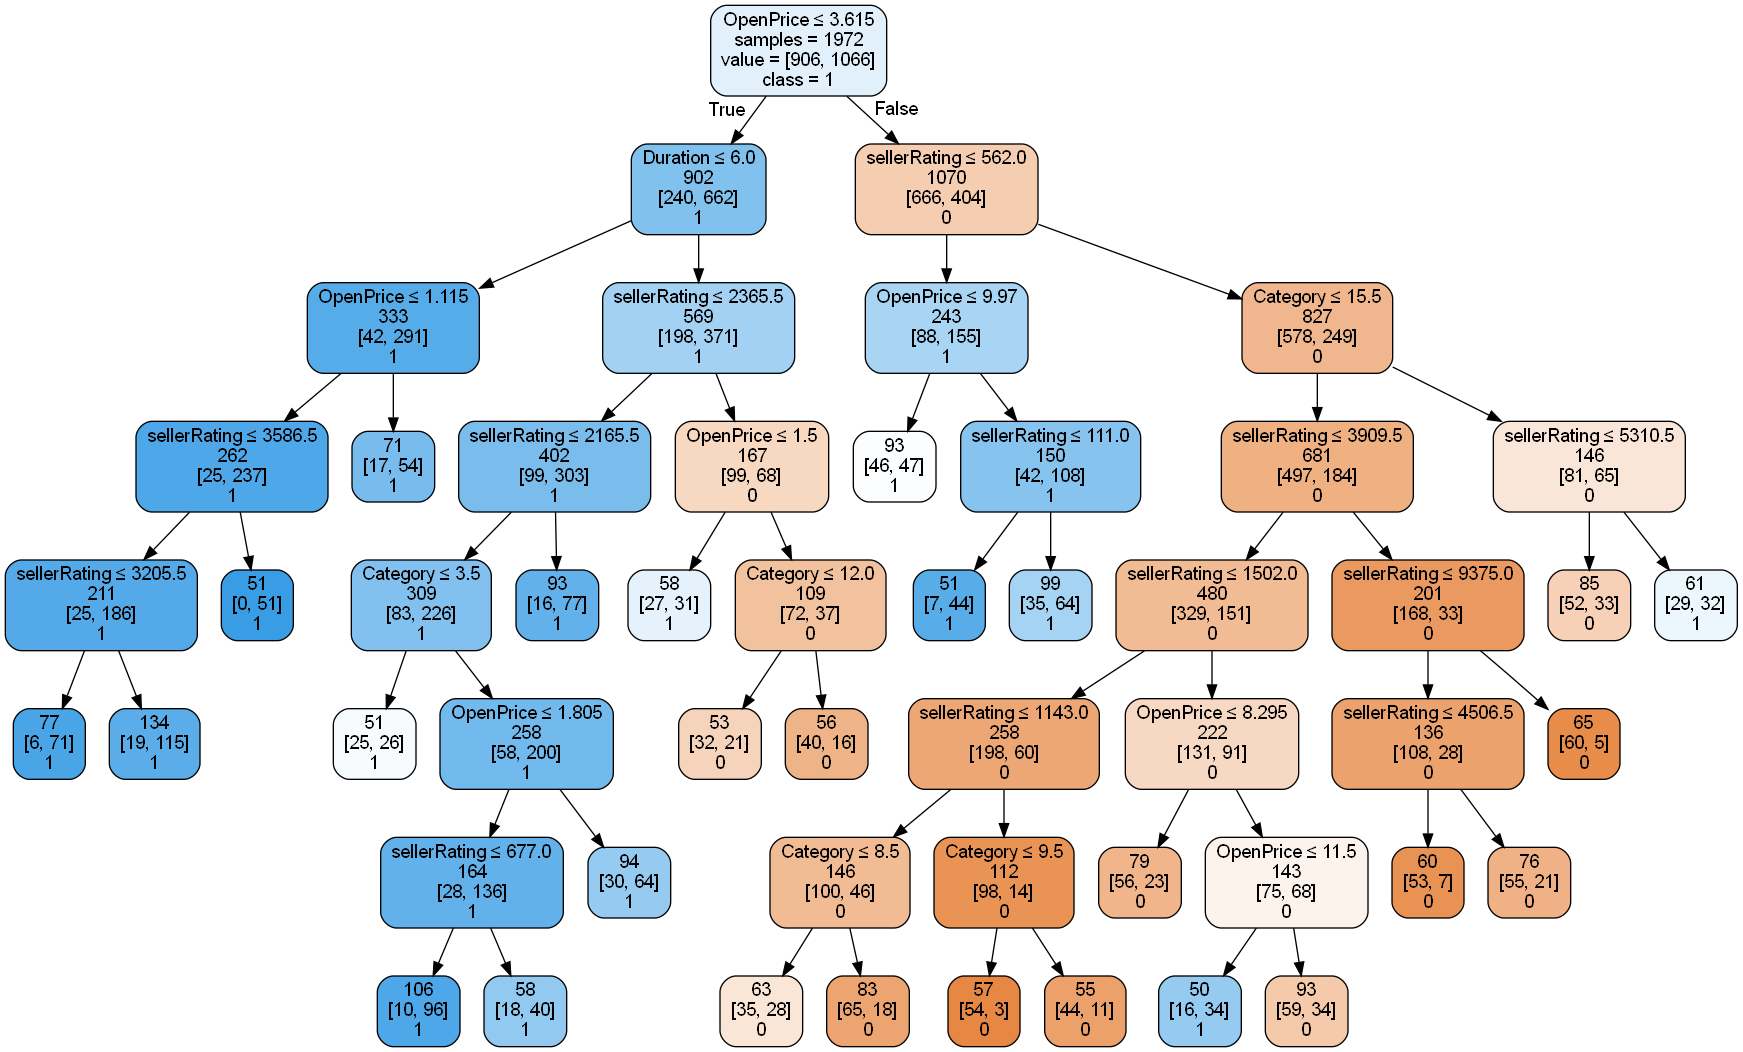

In [84]:
num_features_in_model = classTree.tree_.n_features
print("Number of features in the model:", num_features_in_model)
# Update the feature_names accordingly
feature_names = ebay_df.columns[:num_features_in_model]

# Plot the decision tree
plotDecisionTree(classTree, feature_names=feature_names, class_names=classTree.classes_)


In [85]:
classificationSummary(ebay_df['Competitive'], classTree.predict(ebay_df.drop(columns=['Competitive'])))

Confusion Matrix (Accuracy 0.7358)

       Prediction
Actual   0   1
     0 605 301
     1 220 846
